Mỗi sinh viên sẽ tạo một thư mục One Drive / Google Drive, để chế độ Share Public Read, gửi lại link vào form sau. Mỗi tuần tạo một thư mục, ví dụ: Bài 2, Bài 3, ... Mỗi bài tập sẽ lưu code, data, báo cáo **(Đã viết chi tiết trong file Jupyter Notebook thì không cần viết báo cáo)** vào một thư mục, ví dụ: Bài 2.1, Bài 2.2, ... Bài tập cần upload lên trước 22h ngày chủ nhật hàng tuần.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep Learning/cnn2d_numpy')
print("Changed Directory:", os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed Directory: /content/drive/MyDrive/Colab Notebooks/Deep Learning/cnn2d_numpy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nhận dạng chữ số viết tay với tập MNIST sử dụng CNN. Cải tiến:
+ Các hàm kích hoạt khác nhau.
+ Các phương pháp tiền xử lý dữ liệu đầu vào.
+ Các kỹ thuật khởi tạo trọng số của mạng nơ ron  

Yêu cầu: Chỉ sử dụng Numpy

Bài tập này đã được cải tiến bằng cách phân chia thành các **Package khác nhau theo mô hình của Keras**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Lấy train, validation và test set kết hợp tiền xử lý. Do CNN chạy lâu nên chỉ lấy một số lượng nhỏ tập dữ liệu
1. **Chuẩn hóa dữ liệu**:
   $$
   x_{\text{norm}} = \frac{x - \mu}{\sigma^{}}
   $$
   Do bài lần trước dùng Min-max Normalization nên lần này sẽ thử dùng Standardization

2. **Chuyển nhãn thành one-hot**:
   $$
   y_{\text{one-hot}} = \text{one-hot}(y)
   $$

3. **Xáo trộn dữ liệu**:
   $$
   \text{indices} = \text{random\_permutation}(n)
   $$
   $$
   x, y = x[\text{indices}], y[\text{indices}]
   $$

4. **Chia tập dữ liệu**:
   $$
   x_{\text{train}}, y_{\text{train}} = x[:100], y[:100]
   $$
   $$
   x_{\text{valid}}, y_{\text{valid}} = x[100:150], y[100:150]
   $$
   $$
   x_{\text{test}}, y_{\text{test}} = x_{\text{test}}[:30], y_{\text{test}}[:30]
   $$

5. **Tham số huấn luyện**:
   $$
   E = 15, \quad \eta = [SGD, SGDMomentum, RMSProp, Adam]
   $$
   Tuần này chúng ta thử dùng Adam Optimization, tập trung vào tiền xử lý, khởi tạo trọng số, thay đổi hàm kích hoạt


In [4]:
from tensorflow.keras.datasets import mnist
from utils.preprocessing import std_normalize

(x, y), (x_test, y_test) = mnist.load_data()

x, x_test = std_normalize(x), std_normalize(x_test)

y = np.eye(10)[y]
y_test = np.eye(10)[y_test]

np.random.seed(22)
indices = np.random.permutation(len(x))

x, y = x[indices], y[indices]
x_train, y_train = x[:200], y[:200]
x_valid, y_valid = x[200:250], y[200:250]
x_test, y_test = x_test[:50], y_test[:50]

print(f"Train shape: {x_train.shape}, {y_train.shape}")
print(f"Valid shape: {x_valid.shape}, {y_valid.shape}")
print(f"Test shape: {x_test.shape}, {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (200, 28, 28), (200, 10)
Valid shape: (50, 28, 28), (50, 10)
Test shape: (50, 28, 28), (50, 10)


#### Hiển thị 10 ảnh và nhãn trong tập train

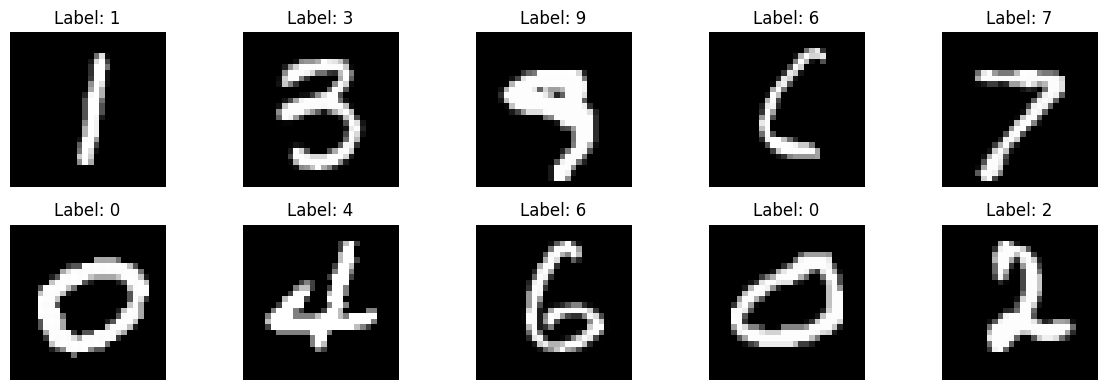

In [5]:
num_images = 10
indices = np.random.choice(x_train.shape[0], num_images, replace=False)
sample_images = x_train[indices]
sample_labels = np.argmax(y_train[indices], axis=1)

plt.figure(figsize=(12, 4))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i], cmap="gray")
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Mạng nơ-ron tích chập (CNN) được thiết kế để phân loại chữ số viết tay từ tập dữ liệu MNIST.  
Dữ liệu đầu vào gồm **250 ảnh** có kích thước **(28 × 28 × 1)** (grayscale).  

1.Cấu trúc mạng gồm:

- **Input Layer**: $(28, 28, 1)$
- **Conv2D (64 filters, kernel size 3×3)**: $(26, 26, 64)$
- **ReLU Activation**
- **Conv2D (32 filters, kernel size 3×3)**: $(24, 24, 32)$
- **ReLU Activation**
- **MaxPooling (2×2)**: $(12, 12, 32)$
- **Flatten Layer**: $(4608)$
- **Fully Connected Layer (FC)**: $(10)$
- **Softmax Activation**

2.Số lượng tham số

Tổng số tham số trong mạng được tính như sau:

- **Conv2D (64 filters, 3 × 3 × 1)**:  
  $64 \times (3 \times 3 \times 1 + 1) = 640$
- **Conv2D (32 filters, 3 × 3 × 64)**:  
  $32 \times (3 \times 3 \times 64 + 1) = 18,464$
- **Fully Connected Layer (FC, 4608 → 10)**:  
  $4608 \times 10 + 10 = 46,090$

**Tổng số tham số của mô hình:**  
$65,194$


Trong bài này, ta sẽ học cách thiết kế theo hướng **tái sử dụng** và **tổng quát hóa** CNN bằng cách định nghĩa các lớp riêng biệt cho từng loại layer như **Conv2D, ReLU, MaxPool, Fully Connected**, v.v. Mỗi lớp sẽ nhận **tham số cần thiết** (số filters, kích thước kernel, stride, padding, v.v.) và triển khai **logic tính toán** trong phương thức `forward()` và **cập nhật tham số** trong phương thức `backward()`. Khi xây dựng mô hình, ta chỉ cần **khởi tạo các lớp này với tham số mong muốn** và **xâu chuỗi chúng lại** để tạo thành mạng hoàn chỉnh.


### **Hàm Kích Hoạt: Sigmoid, Leaky ReLU, Softmax**

#### **1. Hàm kích hoạt Sigmoid**
- **Forward pass:**  
  $$
  a = \frac{1}{1 + e^{-z}}
  $$  
- **Backward pass:**  
  $$
  \frac{da}{dz} = a(1 - a)
  $$  
  (Vì đạo hàm của sigmoid là: $ \sigma'(z) = \sigma(z) (1 - \sigma(z)) $)



#### **2. Hàm kích hoạt Leaky ReLU**
- **Forward pass:**  
  $$
  a = \max(\alpha z, z)
  $$  
  (Trong đó, $ \alpha $ là hệ số nhỏ, thường chọn $ \alpha = 0.01 $)  
- **Backward pass:**  
  $$
  \frac{da}{dz} =
  \begin{cases}
    1, & \text{nếu } z > 0 \\
    \alpha, & \text{nếu } z \leq 0
  \end{cases}
  $$  


#### **3. Hàm kích hoạt Softmax:**
  - **Forward pass:**  
    $$ a_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}} $$
  - **Backward pass:**  
    Gradient của **Softmax kết hợp Cross-Entropy**:
    $$ \frac{\partial L}{\partial z_i} = a_i - y_i $$  
    Trong đó $ y_i $ là giá trị ground truth (one-hot label).


### **Hàm mất mát: Cross-Entropy Loss**
  $$ J = - \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{10} y_k^{(i)} \log(A^{[2]}_k) $$


### **Khởi tạo tham số**

#### **1️. Khởi tạo Random (Ngẫu nhiên)**
Phương pháp đơn giản nhất là lấy các giá trị ngẫu nhiên nhỏ:
$$
W \sim \mathcal{N}(0, 0.05)
$$
hoặc  
$$
W = 0.05 \times \text{random values}
$$

#### **2️. Xavier (Glorot) Initialization**
**Dùng cho: Sigmoid, Tanh**  

Công thức Xavier **Gaussian**:
$$
W \sim \mathcal{N} \left( 0, \frac{1}{\text{D_avg}} \right)
$$
hoặc Xavier **Uniform** (Dùng):
$$
W \sim U \left(-\frac{1}{\text{D_avg}}, \frac{1}{\text{D_avg}} \right)
$$
Trong đó:
$$
\text{D_avg} = \frac{\text{D_in} + \text{D_out}}{2}
$$
- **D_in** = số đầu vào của mỗi neuron.  
- **D_out** = số đầu ra của mỗi neuron.  

#### **3️. He (Kaiming) Initialization**
**Dùng cho: ReLU, Leaky ReLU**  

Công thức He **Gaussian**: (Dùng)
$$
W \sim \mathcal{N} \left( 0, \frac{2}{\text{D_in}} \right)
$$
hoặc He **Uniform**:
$$
W \sim U \left(-\frac{2}{\text{D_in}}, \frac{2}{\text{D_in}} \right)
$$


### **Với hàm kích hoạt Sigmoid, khởi tạo trọng số Random**

In [6]:
from layers.activation import Sigmoid, Softmax, LeakyReLU, ReLU
from layers.convolution import Convolution
from layers.flatten import Flatten
from layers.fully_conected import FullyConnected
from layers.max_pooling import MaxPooling
from layers.batch_norm import BatchNormalization
from models.train import NNTrainer
from losses.cross_entropy import cross_entropy_loss
from optimizers.adam import Adam
from utils.visualize import plot_history



Training...
Epoch 1, Loss: 4.7094, Accuracy: 12.00%
Epoch 2, Loss: 3.1180, Accuracy: 10.00%
Epoch 3, Loss: 2.6830, Accuracy: 13.50%
--> Evaluation: Loss: 2.6108, Accuracy: 12.00%
Epoch 4, Loss: 2.2324, Accuracy: 25.00%
Epoch 5, Loss: 1.7820, Accuracy: 41.00%
Epoch 6, Loss: 1.4037, Accuracy: 51.50%
--> Evaluation: Loss: 1.3220, Accuracy: 48.00%
Epoch 7, Loss: 1.1259, Accuracy: 65.50%
Epoch 8, Loss: 0.9329, Accuracy: 74.50%
Epoch 9, Loss: 0.7982, Accuracy: 78.50%
--> Evaluation: Loss: 0.8411, Accuracy: 78.00%
Epoch 10, Loss: 0.7005, Accuracy: 83.50%
Epoch 11, Loss: 0.6255, Accuracy: 84.50%
Epoch 12, Loss: 0.5650, Accuracy: 86.00%
--> Evaluation: Loss: 0.7171, Accuracy: 80.00%
Epoch 13, Loss: 0.5142, Accuracy: 86.50%
Epoch 14, Loss: 0.4702, Accuracy: 87.00%
Epoch 15, Loss: 0.4316, Accuracy: 89.00%
--> Evaluation: Loss: 0.6682, Accuracy: 82.00%


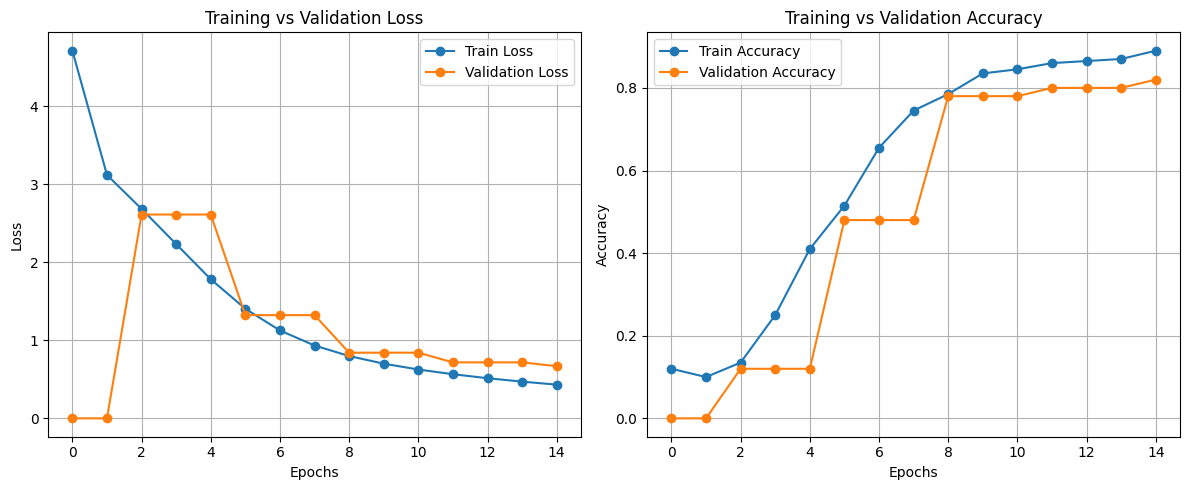

In [7]:
model = NNTrainer([
    Convolution(num_filters=64, kernel_size=(3, 3), weight_init="random"),
    Sigmoid(),

    Convolution(num_filters=32, kernel_size=(3, 3), weight_init="random"),
    Sigmoid(),

    MaxPooling(size=2, stride=2),
    Flatten(),
    FullyConnected(input_size=4608, output_size=10),
    Softmax()
], loss_function=cross_entropy_loss, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, epochs=15, optimizer=Adam())

train_losses, train_accuracies, val_losses, val_accuracies = model.fit()
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [8]:
print("Test Evaluation:")
model.evaluate(x_test, y_test)

Test Evaluation:
--> Evaluation: Loss: 0.5886, Accuracy: 84.00%


(0.588648085830145, 0.84)

### **Với hàm kích hoạt Sigmoid, khởi tạo trọng số Xavier**

Training...
Epoch 1, Loss: 4.7692, Accuracy: 11.50%
Epoch 2, Loss: 3.1392, Accuracy: 11.50%
Epoch 3, Loss: 2.6449, Accuracy: 18.50%
--> Evaluation: Loss: 2.4803, Accuracy: 12.00%
Epoch 4, Loss: 2.1677, Accuracy: 30.00%
Epoch 5, Loss: 1.7347, Accuracy: 43.50%
Epoch 6, Loss: 1.3909, Accuracy: 53.50%
--> Evaluation: Loss: 1.2761, Accuracy: 54.00%
Epoch 7, Loss: 1.1388, Accuracy: 60.50%
Epoch 8, Loss: 0.9591, Accuracy: 69.50%
Epoch 9, Loss: 0.8294, Accuracy: 75.00%
--> Evaluation: Loss: 0.8055, Accuracy: 80.00%
Epoch 10, Loss: 0.7328, Accuracy: 78.50%
Epoch 11, Loss: 0.6576, Accuracy: 79.50%
Epoch 12, Loss: 0.5966, Accuracy: 82.50%
--> Evaluation: Loss: 0.6760, Accuracy: 84.00%
Epoch 13, Loss: 0.5452, Accuracy: 84.50%
Epoch 14, Loss: 0.5006, Accuracy: 85.50%
Epoch 15, Loss: 0.4611, Accuracy: 87.00%
--> Evaluation: Loss: 0.6369, Accuracy: 82.00%


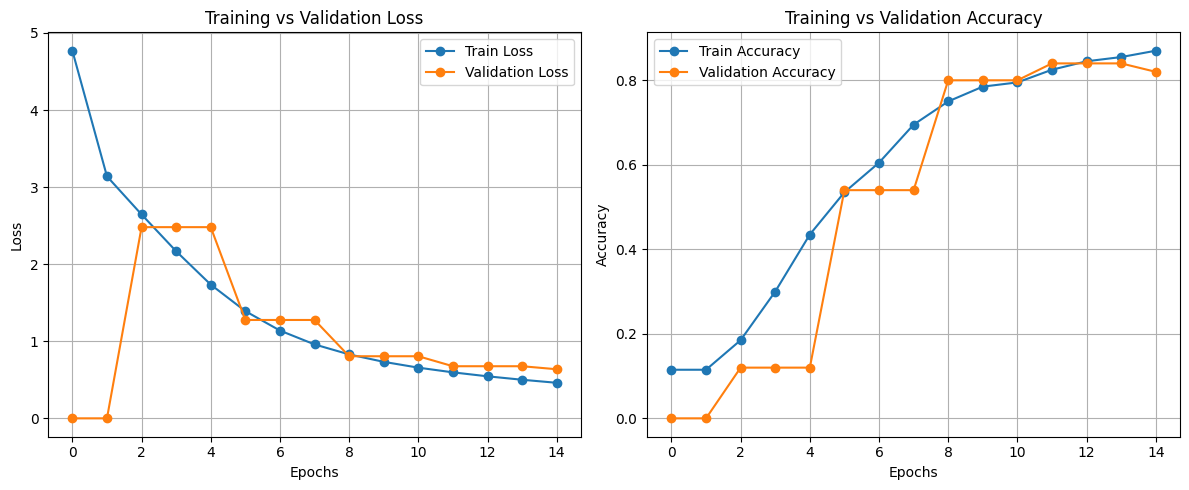

In [9]:
model = NNTrainer([
    Convolution(num_filters=64, kernel_size=(3, 3), weight_init="xavier"),
    Sigmoid(),
    Convolution(num_filters=32, kernel_size=(3, 3), weight_init="xavier"),
    Sigmoid(),
    MaxPooling(size=2, stride=2),
    Flatten(),
    FullyConnected(input_size=4608,output_size=10),
    Softmax()
], loss_function=cross_entropy_loss, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, epochs=15, optimizer=Adam())

train_losses, train_accuracies, val_losses, val_accuracies = model.fit()
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
print("Test Evaluation:")
model.evaluate(x_test, y_test)

Test Evaluation:
--> Evaluation: Loss: 0.6563, Accuracy: 80.00%


(0.6563397606319387, 0.8)

### **Với hàm kích hoạt ReLU, khởi tạo trọng số He**

Training...
Epoch 1, Loss: 0.4254, Accuracy: 89.50%
Epoch 2, Loss: 0.3929, Accuracy: 90.50%
Epoch 3, Loss: 0.3632, Accuracy: 91.00%
--> Evaluation: Loss: 0.6093, Accuracy: 84.00%
Epoch 4, Loss: 0.3360, Accuracy: 92.50%
Epoch 5, Loss: 0.3111, Accuracy: 93.00%
Epoch 6, Loss: 0.2882, Accuracy: 94.50%
--> Evaluation: Loss: 0.5847, Accuracy: 82.00%
Epoch 7, Loss: 0.2672, Accuracy: 94.50%
Epoch 8, Loss: 0.2477, Accuracy: 95.00%
Epoch 9, Loss: 0.2297, Accuracy: 95.50%
--> Evaluation: Loss: 0.5633, Accuracy: 80.00%
Epoch 10, Loss: 0.2130, Accuracy: 96.00%
Epoch 11, Loss: 0.1975, Accuracy: 96.00%
Epoch 12, Loss: 0.1830, Accuracy: 96.00%
--> Evaluation: Loss: 0.5452, Accuracy: 78.00%
Epoch 13, Loss: 0.1695, Accuracy: 96.00%
Epoch 14, Loss: 0.1569, Accuracy: 97.50%
Epoch 15, Loss: 0.1451, Accuracy: 98.00%
--> Evaluation: Loss: 0.5310, Accuracy: 78.00%


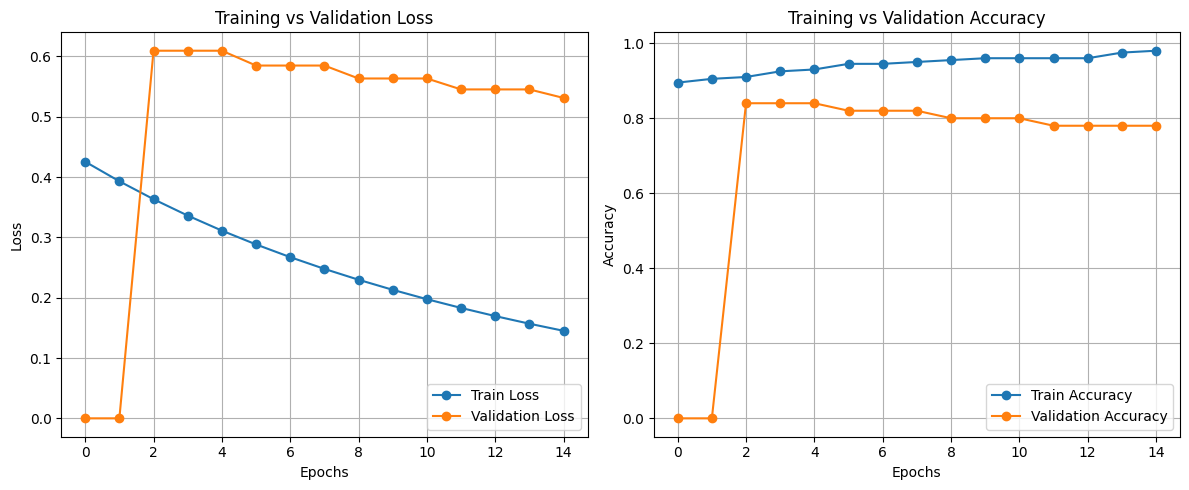

In [11]:
model2 = NNTrainer([
    Convolution(num_filters=64, kernel_size=(3, 3), weight_init="he"),
    ReLU(),
    Convolution(num_filters=32, kernel_size=(3, 3), weight_init="he"),
    ReLU(),
    MaxPooling(size=2, stride=2),
    Flatten(),
    FullyConnected(input_size=4608,output_size=10),
    Softmax()
], loss_function=cross_entropy_loss, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, epochs=15, optimizer=Adam())

train_losses, train_accuracies, val_losses, val_accuracies = model.fit()
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [15]:
print("Test Evaluation:")
model2.evaluate(x_test, y_test)

Test Evaluation:
--> Evaluation: Loss: 4.9972, Accuracy: 20.00%


(4.9971615736581825, 0.2)

### **Với hàm kích hoạt LeakyReLU, khởi tạo trọng số He**

Training...
Epoch 1, Loss: 0.1341, Accuracy: 98.00%
Epoch 2, Loss: 0.1238, Accuracy: 98.00%
Epoch 3, Loss: 0.1143, Accuracy: 98.00%
--> Evaluation: Loss: 0.5202, Accuracy: 78.00%
Epoch 4, Loss: 0.1054, Accuracy: 99.00%
Epoch 5, Loss: 0.0972, Accuracy: 99.00%
Epoch 6, Loss: 0.0895, Accuracy: 99.00%
--> Evaluation: Loss: 0.5109, Accuracy: 78.00%
Epoch 7, Loss: 0.0824, Accuracy: 99.00%
Epoch 8, Loss: 0.0758, Accuracy: 99.00%
Epoch 9, Loss: 0.0697, Accuracy: 99.50%
--> Evaluation: Loss: 0.5029, Accuracy: 84.00%
Epoch 10, Loss: 0.0641, Accuracy: 99.50%
Epoch 11, Loss: 0.0588, Accuracy: 99.50%
Epoch 12, Loss: 0.0540, Accuracy: 99.50%
--> Evaluation: Loss: 0.4973, Accuracy: 82.00%
Epoch 13, Loss: 0.0496, Accuracy: 99.50%
Epoch 14, Loss: 0.0455, Accuracy: 99.50%
Epoch 15, Loss: 0.0417, Accuracy: 99.50%
--> Evaluation: Loss: 0.4945, Accuracy: 80.00%


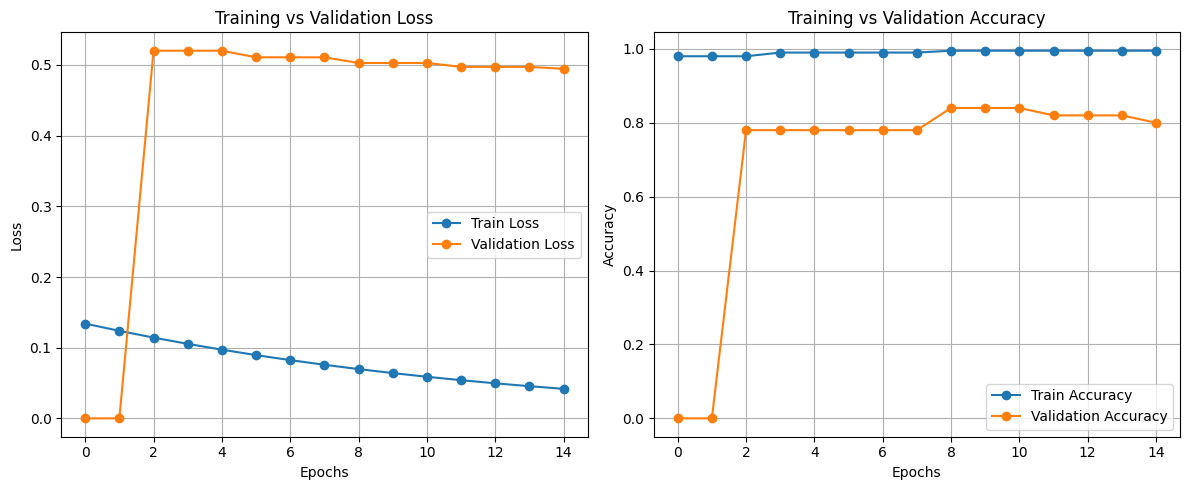

In [13]:
model3 = NNTrainer([
    Convolution(num_filters=64, kernel_size=(3, 3), weight_init="he"),
    LeakyReLU(),
    Convolution(num_filters=32, kernel_size=(3, 3), weight_init="he"),
    LeakyReLU(),
    MaxPooling(size=2, stride=2),
    Flatten(),
    FullyConnected(input_size=4608,output_size=10),
    Softmax()
], loss_function=cross_entropy_loss, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, epochs=15, optimizer=Adam())

train_losses, train_accuracies, val_losses, val_accuracies = model.fit()
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [14]:
print("Test Evaluation:")
model3.evaluate(x_test, y_test)

Test Evaluation:
--> Evaluation: Loss: 4.5826, Accuracy: 22.00%


(4.58261396520758, 0.22)

Hai mô hình đầu tiên dùng Sigmoid với khởi tạo mặc định và Xavier chạy ổn trong khi hai mô hình sau dùng ReLU và Leaky ReLU với khởi tạo He bị overfitting.

ReLU và Leaky ReLU giúp train tốt hơn nhưng có xu hướng overfit

+ Các hàm kích hoạt như ReLU và Leaky ReLU cùng với He Initialization giúp mô hình học nhanh hơn, dẫn đến độ chính xác train rất cao.

+ Tuy nhiên, nếu mô hình quá phức tạp so với dữ liệu, nó có thể học cả nhiễu (noise) từ tập train thay vì học quy luật tổng quát.

+ Điều này dẫn đến train accuracy cao nhưng test accuracy thấp.

Sigmoid hoạt động kém khi train nhưng lại tổng quát hơn

+ Sigmoid có vanishing gradient khiến việc học chậm hơn, nhưng điều này cũng giúp tránh overfitting ở mức độ nào đó.

+ Khi test, do mô hình không học quá sát dữ liệu train, nó lại tổng quát hóa tốt hơn, nên test accuracy cao hơn ReLU.